In [2]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, overview
from lob_data_utils.svm_calculation import lob_svm

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [3]:
data_length = 10000
stock = '11869'

In [4]:
df, df_cv, df_test = lob.load_prepared_data(
    stock, data_dir='../queue_imbalance/data/prepared', cv=True, length=data_length)

In [ ]:
## Overview with z score

In [29]:
overview_z_score = overview.Overview(stock, data_length, results_dir='results_z_score', 
                                     data_dir='../gaussian_filter/data_gdf_z_score/', suffix='_z_score')
K = 50
length = data_length
rr = [0.01, 0.05, 0.1, 0.5, 1.0]
ss = [0.01, 0.05, 0.1, 0.5, 1.0]
Cs = [1, 10, 100, 1000, 10000]
Kn = 10

df_gdf_log_z = overview_z_score.write_gdf_logistic(K=K, Kn=Kn, rr=rr, ss=ss, Cs=Cs)
df_gdf_log_z.drop(columns=[c for c in df_gdf_log_z.columns if 'Unnamed' in c], inplace=True)
df_gdf_log_z.sort_values(by='roc_cv_score', ascending=False).head()

Results read from file


,c,roc_cv_score,roc_train_score,K,Kn,r,s,stock
73,1000,0.740826,0.754499,50,10,0.10,1.0,11869
49,10000,0.574606,0.497036,50,10,0.05,1.0,11869
12,100,0.564429,0.496037,50,10,0.01,0.1,11869
61,10,0.551941,0.502693,50,10,0.10,0.1,11869
62,100,0.549805,0.502671,50,10,0.10,0.1,11869


In [31]:
overview_regular = overview.Overview(stock, data_length)

K = 50
length = data_length
rr = [0.01, 0.05, 0.1, 0.5, 1.0]
ss = [0.01, 0.05, 0.1, 0.5, 1.0]
Cs = [1, 10, 100, 1000, 10000]
Kn = 10

df_gdf_log_reg = overview_regular.write_gdf_logistic(K=K, Kn=Kn, rr=rr, ss=ss, Cs=Cs)
df_gdf_log_reg.drop(columns=[c for c in df_gdf_log_reg.columns if 'Unnamed' in c], inplace=True)
df_gdf_log_reg.sort_values(by='roc_cv_score', ascending=False).head()

Results read from file


,c,roc_cv_score,roc_train_score,K,Kn,r,s,stock
19,10000,0.740870,0.548672,50,10,0.01,0.5,11869
21,10,0.740870,0.454379,50,10,0.01,1.0,11869
86,10,0.617156,0.517427,50,10,0.50,0.1,11869
60,1,0.610218,0.510433,50,10,0.10,0.1,11869
110,1,0.610218,0.510426,50,10,1.00,0.1,11869


In [36]:
def compare(df_gdf_res, df_gdf_log_res):
    res_best = df_gdf_res.sort_values(by='roc_cv_score', ascending=False)
    df_gdf_log_res = df_gdf_log_res.sort_values(by='roc_cv_score', ascending=False)
    comp = []
    for i, row in res_best.iterrows():
        r = df_gdf_log_res[df_gdf_log_res['r'] == row['r']][df_gdf_log_res['s'] == row['s']].iloc[0]
        comp.append({
            'roc_cv_score': row['roc_cv_score'],
            'roc_train_score': row['roc_train_score'],
            'r': row['r'],
            's': row['s'],
            'roc_cv_score_z': r['roc_cv_score'],
            'roc_train_score_z': r['roc_train_score']
        })
    return pd.DataFrame(comp).sort_values(
        by=['roc_cv_score_z', 'roc_cv_score'], ascending=False).dropna()
compare(df_gdf_log_reg, df_gdf_log_z).head()

,r,roc_cv_score,roc_cv_score_z,roc_train_score,roc_train_score_z,s
39,0.1,0.523668,0.740826,0.529067,0.754499,1.0
52,0.1,0.516417,0.740826,0.518325,0.754499,1.0
74,0.1,0.502648,0.740826,0.521429,0.754499,1.0
96,0.1,0.488840,0.740826,0.521251,0.754499,1.0
101,0.1,0.486433,0.740826,0.524715,0.754499,1.0


## Let's check on test!

In [37]:
best_gdf_log_z = df_gdf_log_z.sort_values(by=['roc_cv_score', 'roc_train_score'], ascending=False).iloc[0]

best_gdf_log_reg = df_gdf_log_reg.sort_values(by=['roc_cv_score', 'roc_train_score'], ascending=False).iloc[0]
res_dict = OrderedDict({
    'gdf_log_z': best_gdf_log_z,
    'gdf_log_reg': best_gdf_log_reg,
})

In [40]:
def gdf_log_classification(df, K, C=1000):
    gdf_columns = ['gdf_' + str(i) for i in range(0, K)]
    clf = LogisticRegression(C=C)
    X = df.loc[:, gdf_columns]
    y = df['mid_price_indicator'].values.reshape(-1, 1)
    y[0] = 0
    clf.fit(X, y)
    return clf

filename = 'gdf_{}_len{}_r{}_s{}_K{}'.format(
    stock, length, best_gdf_log_reg['r'], best_gdf_log_reg['s'], int(best_gdf_log_reg['K']))
dfs, dfs_cv, dfs_test = lob.load_prepared_data(
    filename, data_dir='../gaussian_filter/data_gdf/', cv=True, length=length)
svm_gdf_clf = gdf_log_classification(dfs, K, C=best_gdf_log_reg['c'])
gdf_columns = ['gdf_' + str(i) for i in range(0, K)]
pred_test = svm_gdf_clf.predict(dfs_test.loc[:, gdf_columns])
roc_test = roc_auc_score(pred_test, dfs_test['mid_price_indicator'])
best_gdf_log_reg['roc_test_score'] = roc_test
roc_test

0.5439456704576837

In [42]:
def gdf_log_classification(df, K, C=1000):
    gdf_columns = ['gdf_' + str(i) for i in range(0, K)]
    clf = LogisticRegression(C=C)
    X = df.loc[:, gdf_columns]
    y = df['mid_price_indicator'].values.reshape(-1, 1)
    y[0] = 0
    clf.fit(X, y)
    return clf

filename = 'gdf_{}_len{}_r{}_s{}_K{}_z_score'.format(
    stock, length, best_gdf_log_z['r'], best_gdf_log_z['s'], int(best_gdf_log_z['K']))
dfs, dfs_cv, dfs_test = lob.load_prepared_data(
    filename, data_dir='../gaussian_filter/data_gdf_z_score/', cv=True)
svm_gdf_clf = gdf_log_classification(dfs, K, C=best_gdf_log_z['c'])
gdf_columns = ['gdf_' + str(i) for i in range(0, K)]
pred_test = svm_gdf_clf.predict(dfs_test.loc[:, gdf_columns])
roc_test = roc_auc_score(pred_test, dfs_test['mid_price_indicator'])
best_gdf_log_z['roc_test_score'] = roc_test
roc_test

0.5319347640776212

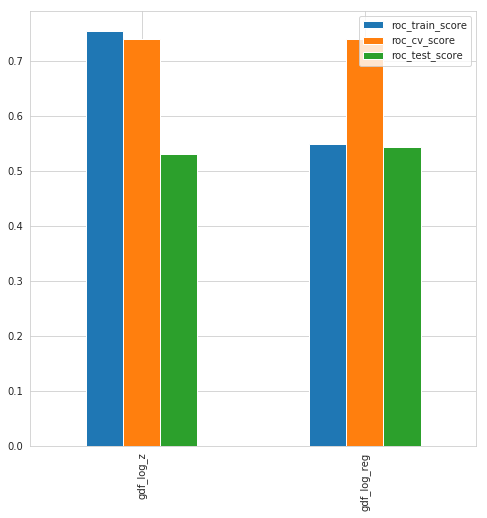

In [43]:
res = []
for k, v in res_dict.items():
    dd = v.to_dict()
    dd['type'] = k
    res.append(dd)
df_res = pd.DataFrame(res)

df_res[['roc_train_score', 'roc_cv_score', 'roc_test_score']].plot(kind='bar', figsize=(8, 8))
d = plt.xticks(list(range(len(res_dict.keys()))), list(res_dict.keys()))
plt.legend(loc='upper right')

## Conclusion

No, z score normalizer is not what I want to continue with.